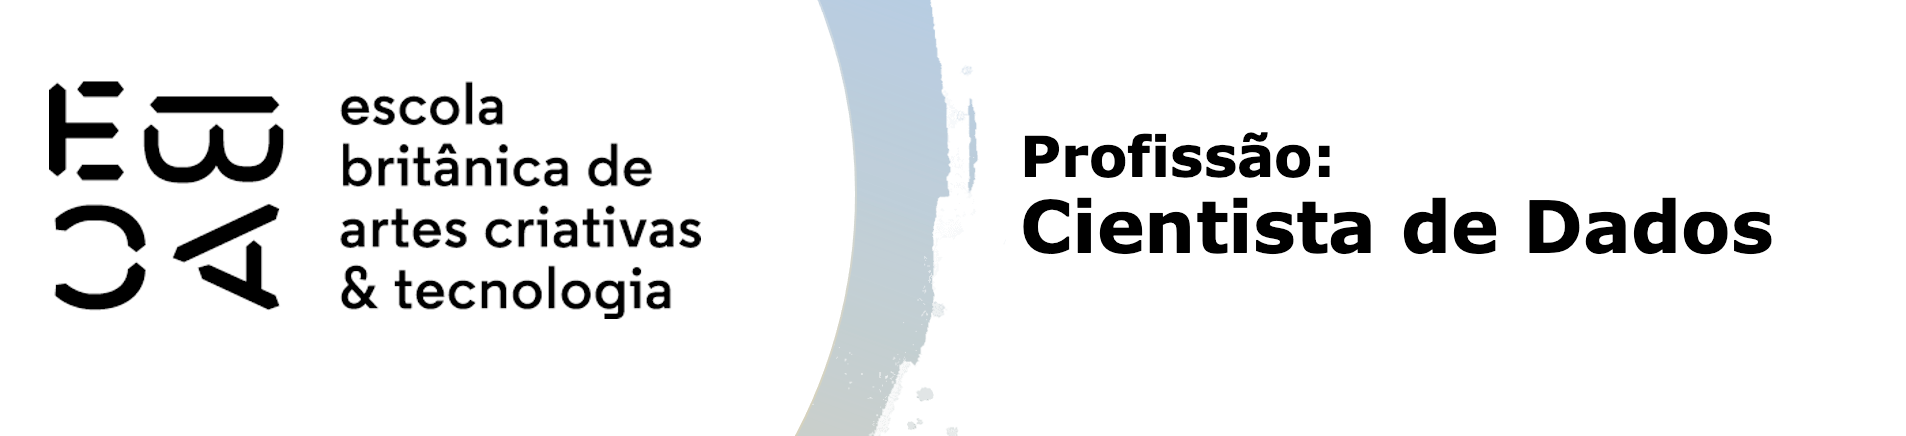

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ks_2samp, t, zscore
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

df = pd.read_feather('credit_scoring.ftr')
df.head()

ModuleNotFoundError: No module named 'pandas'

In [11]:
print(f'Número de linhas: {df.shape[0]} \nNúmero de colunas: {df.shape[1]}')
df.mau.value_counts(normalize=True)

Número de linhas: 750000 
Número de colunas: 15


mau
False    0.921809
True     0.078191
Name: proportion, dtype: float64

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [12]:
# remover 'index' do DataFrame
df.drop(['index'], axis=1, inplace=True)
df.columns

Index(['data_ref', 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'mau'],
      dtype='object')

In [13]:
# Ordenar o DataFrame por data_ref para garantir que as safras estão na ordem correta
df_2 = df.sort_values(by='data_ref')

# Verificar se a ordenação está correta
print(df_2['data_ref'].head())
print(df_2['data_ref'].tail())

# Encontrar as datas únicas e a terceira última safra
unique_dates = df_2['data_ref'].unique()
third_last_safra = unique_dates[-3]

# Encontrar datas únicas em ordem
unique_dates = df_2['data_ref'].unique()
print(unique_dates)

# Identificar a terceira última safra
third_last_safra = unique_dates[-3]
print(f"Terceira última safra: {third_last_safra}")

0       2015-01-01
33328   2015-01-01
33329   2015-01-01
33330   2015-01-01
33331   2015-01-01
Name: data_ref, dtype: datetime64[ns]
716668   2016-03-01
716669   2016-03-01
716670   2016-03-01
716648   2016-03-01
749999   2016-03-01
Name: data_ref, dtype: datetime64[ns]
<DatetimeArray>
['2015-01-01 00:00:00', '2015-02-01 00:00:00', '2015-03-01 00:00:00',
 '2015-04-01 00:00:00', '2015-05-01 00:00:00', '2015-06-01 00:00:00',
 '2015-07-01 00:00:00', '2015-08-01 00:00:00', '2015-09-01 00:00:00',
 '2015-10-01 00:00:00', '2015-11-01 00:00:00', '2015-12-01 00:00:00',
 '2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 15, dtype: datetime64[ns]
Terceira última safra: 2016-01-01 00:00:00


In [14]:
# Separar dataset em treinamento e validação
df_train = df_2[df_2['data_ref'] < third_last_safra]
df_val = df_2[df_2['data_ref'] >= third_last_safra]

# Verificar tamanhos dos conjuntos
print(f"Conjunto de treinamento: {df_train.shape}")
print(f"Conjunto de validação: {df_val.shape}")

Conjunto de treinamento: (600000, 14)
Conjunto de validação: (150000, 14)


In [15]:
# Definir as features e o target
features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
target = 'mau'

# Verificar se todas as features estão presentes no dataset de treinamento
print(df_train[features].head())

      sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
0        F                N               N           0   Empresário   
33328    M                S               S           1  Assalariado   
33329    F                N               N           0  Assalariado   
33330    M                N               S           1  Assalariado   
33331    F                N               S           1  Assalariado   

                  educacao estado_civil tipo_residencia  idade  tempo_emprego  \
0                    Médio     Solteiro            Casa     43       6.873973   
33328                Médio       Casado            Casa     41       8.134247   
33329    Superior completo     Solteiro            Casa     26       1.424658   
33330  Superior incompleto       Casado            Casa     37      15.449315   
33331                Médio       Casado            Casa     30       0.369863   

       qt_pessoas_residencia     renda  
0                        1.0   2515.39 

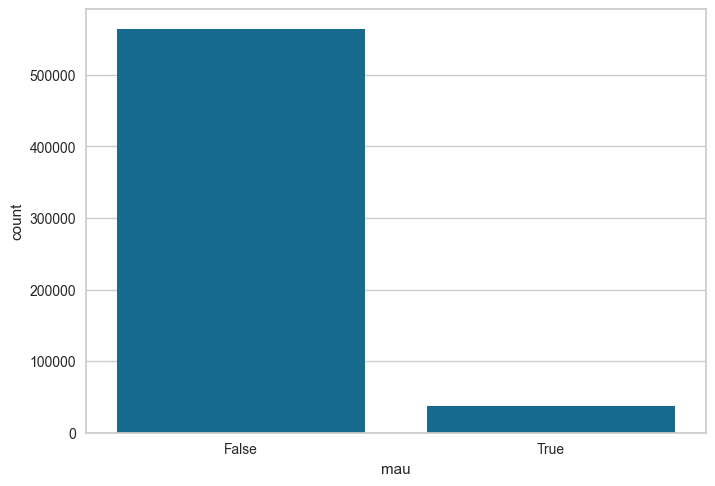

In [16]:
# EDA BÁSICA
sns.countplot(x='mau', data=df_train)
plt.show();

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [29]:
# Lista de variáveis qualitativas disponíveis
qualitative_vars = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

# Descrição das variáveis qualitativas
for var in qualitative_vars:
    if var in df_2.columns:
        print(f"\nDistribuição de '{var}':")
        print(df_2[var].value_counts())
        print(df_2[var].value_counts(normalize=True) * 100)  # Distribuição percentual
    else:
        print(f"\nVariável '{var}' não encontrada no DataFrame.")

# Lista de variáveis quantitativas disponíveis
quantitative_vars = ['idade', 'renda', 'tempo_emprego', 'qt_pessoas_residencia', 'qtd_filhos']

# Descrição das variáveis quantitativas
if quantitative_vars:
    quantitative_description = df_2[quantitative_vars].describe()
    print("\nEstatísticas descritivas para variáveis quantitativas:")
    print(quantitative_description)
else:
    print("Nenhuma variável quantitativa encontrada no DataFrame.")


Distribuição de 'sexo':
sexo
F    496317
M    245100
Name: count, dtype: int64
sexo
F    66.941681
M    33.058319
Name: proportion, dtype: float64

Distribuição de 'posse_de_veiculo':
posse_de_veiculo
N    451451
S    289966
Name: count, dtype: int64
posse_de_veiculo
N    60.890295
S    39.109705
Name: proportion, dtype: float64

Distribuição de 'posse_de_imovel':
posse_de_imovel
S    497365
N    244052
Name: count, dtype: int64
posse_de_imovel
S    67.083032
N    32.916968
Name: proportion, dtype: float64

Distribuição de 'tipo_renda':
tipo_renda
Assalariado         380765
Empresário          171191
Pensionista         126265
Servidor público     62835
Bolsista               361
Name: count, dtype: int64
tipo_renda
Assalariado         51.356389
Empresário          23.089705
Pensionista         17.030227
Servidor público     8.474988
Bolsista             0.048691
Name: proportion, dtype: float64

Distribuição de 'educacao':
educacao
Médio                  501047
Superior completo     

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [11]:
# Criar coluna 'mau' 
df_2['mau'] = df_2['renda'] < 2000

def calculate_iv(data, feature, target, bins=10):
    # Binarizar a variável alvo se não estiver binarizada
    if data[target].dtype != np.dtype('bool'):
        data[target] = data[target].astype(bool)
    
    # Discretizar variáveis contínuas em bins
    if pd.api.types.is_numeric_dtype(data[feature]):
        data[feature] = pd.qcut(data[feature], q=bins, duplicates='drop')
    
    # Contagem dos grupos de bons e maus
    grouped = data.groupby(feature)[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'bads']
    grouped['goods'] = grouped['total'] - grouped['bads']
    
    # Calcular proporções de bons e maus
    grouped['good_dist'] = grouped['goods'] / grouped['goods'].sum()
    grouped['bad_dist'] = grouped['bads'] / grouped['bads'].sum()
    
    # Calcular o WOE (Weight of Evidence) e o IV
    grouped['woe'] = np.log(grouped['good_dist'] / grouped['bad_dist']).replace({np.inf: 0, -np.inf: 0})
    grouped['iv'] = (grouped['good_dist'] - grouped['bad_dist']) * grouped['woe']
    
    iv = grouped['iv'].sum()
    return iv

# Lista de variáveis para calcular o IV
features = ['sexo', 'idade', 'renda']

# Calcular o IV de cada variável
iv_values = {}
for feature in features:
    iv = calculate_iv(df, feature, 'mau')
    iv_values[feature] = iv
    print(f"Information Value de {feature}: {iv:.4f}")

Information Value de sexo: 0.0022
Information Value de idade: 0.0208
Information Value de renda: 1.1634


C:\Users\marce\AppData\Local\Temp\ipykernel_14444\3092676669.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(feature)[target].agg(['count', 'sum'])
C:\Users\marce\AppData\Local\Temp\ipykernel_14444\3092676669.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(feature)[target].agg(['count', 'sum'])


In [12]:
# Verificar a distribuição de 'mau' para cada variável
for feature in features:
    print(f"\nDistribuição de 'mau' por '{feature}':")
    print(df.groupby(feature)['mau'].value_counts(normalize=True))


Distribuição de 'mau' por 'sexo':
sexo  mau  
F     False    0.919478
      True     0.080522
M     False    0.926603
      True     0.073397
Name: proportion, dtype: float64

C:\Users\marce\AppData\Local\Temp\ipykernel_14444\4222785129.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(feature)['mau'].value_counts(normalize=True))
C:\Users\marce\AppData\Local\Temp\ipykernel_14444\4222785129.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(feature)['mau'].value_counts(normalize=True))




Distribuição de 'mau' por 'idade':
idade           mau  
(21.999, 29.0]  False    0.898211
                True     0.101789
(29.0, 33.0]    False    0.913427
                True     0.086573
(33.0, 36.0]    False    0.919009
                True     0.080991
(36.0, 40.0]    False    0.920593
                True     0.079407
(40.0, 43.0]    False    0.930049
                True     0.069951
(43.0, 47.0]    False    0.925562
                True     0.074438
(47.0, 51.0]    False    0.935800
                True     0.064200
(51.0, 55.0]    False    0.933138
                True     0.066862
(55.0, 60.0]    False    0.927717
                True     0.072283
(60.0, 68.0]    False    0.920367
                True     0.079633
Name: proportion, dtype: float64

Distribuição de 'mau' por 'renda':
renda                    mau  
(107.669, 1753.384]      False    0.720747
                         True     0.279253
(1753.384, 2860.64]      False    0.848846
                         True   

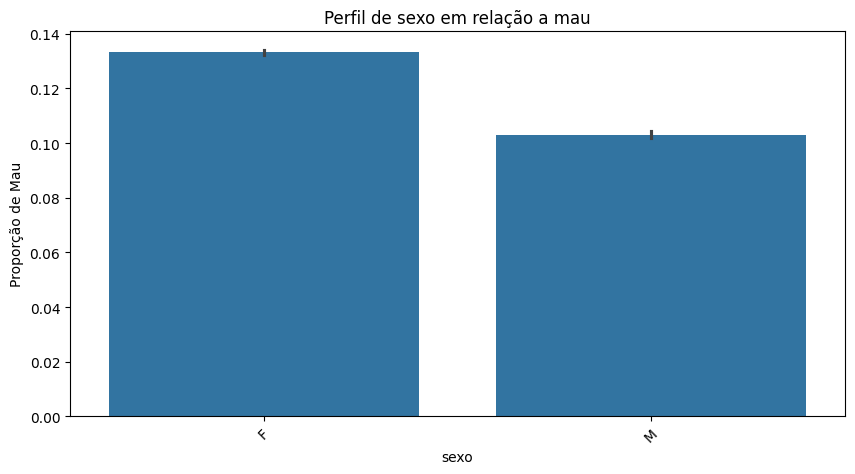

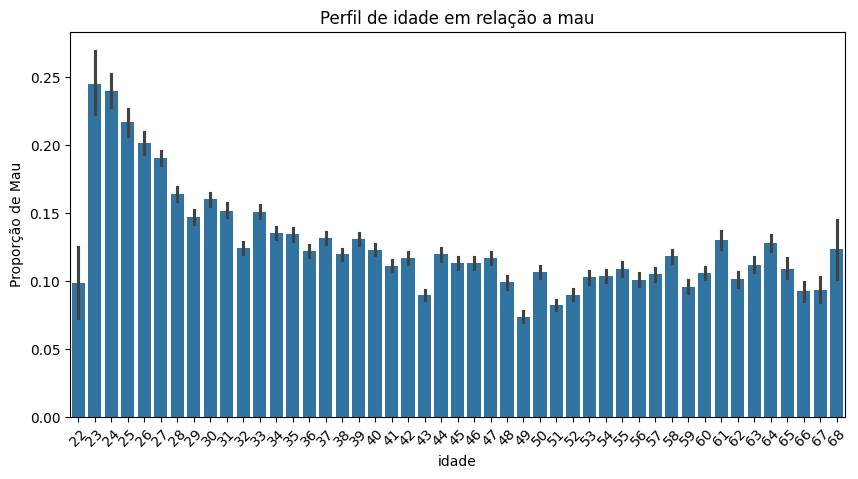

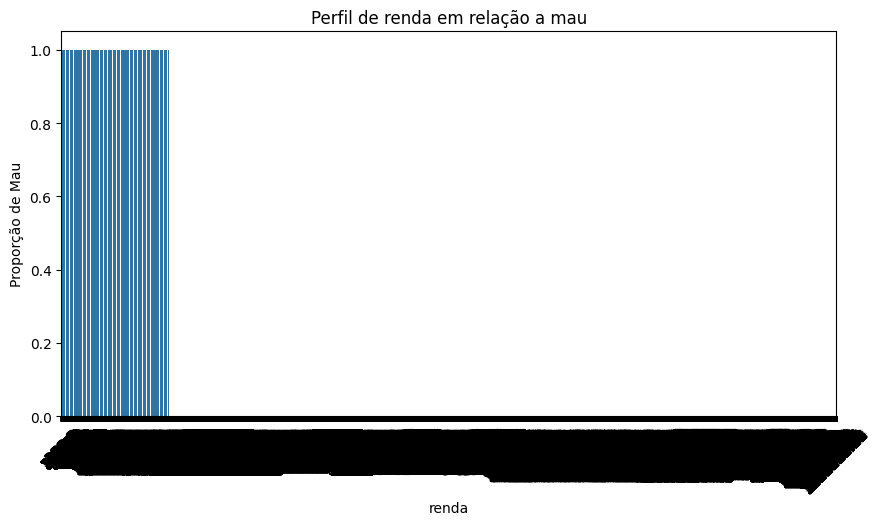

In [13]:
# Função para plotar gráficos de perfis
def plot_profile(data, feature, target):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=feature, y=target, data=data, estimator=np.mean)
    plt.title(f"Perfil de {feature} em relação a {target}")
    plt.ylabel('Proporção de Mau')
    plt.xlabel(feature)
    plt.xticks(rotation=45)
    plt.show();


for feature in features:
    plot_profile(df_2, feature, 'mau')

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [14]:
df_2.isna().sum()

data_ref                      0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [31]:
df_2.fillna({'tempo_emprego': df_2['tempo_emprego'].median()}, inplace=True)
df_2.tempo_emprego.isna().sum()

for col in df_2.select_dtypes(include='object').columns:
    df_2[col].fillna(df_2[col].mode()[0], inplace=True)

In [32]:
# Remover outliers usando o IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # Filtrar valores dentro de 1.5 * IQR
    return df[(df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))]

# Aplicar a remoção de outliers
df_2 = remove_outliers(df_2, 'renda')
df_2 = remove_outliers(df_2, 'idade')
df_2 = remove_outliers(df_2, 'tempo_emprego')

In [16]:
# Verificar a presença de zeros em variáveis potencialmente afetadas
zero_counts = df_2[['qtd_filhos', 'tempo_emprego', 'qt_pessoas_residencia']].apply(lambda x: (x==0).sum())
zero_counts

qtd_filhos               517331
tempo_emprego                 0
qt_pessoas_residencia         0
dtype: int64

In [41]:
# Criar uma variável indicadora para zero
df_2['qtd_filhos_zero'] = (df_2['qtd_filhos'] == 0).astype(int)
df_2['qt_pessoas_residencia_zero'] = (df_2['qt_pessoas_residencia'] == 0).astype(int)
df_2['tempo_emprego_zero'] = (df_2['tempo_emprego'] == 0).astype(int)


In [18]:
# Análise mais detalhada de zeros em 'qtd_filhos'
print(df_2.groupby('qtd_filhos')['mau'].mean())

qtd_filhos
0     0.118999
1     0.135060
2     0.128131
3     0.130811
4     0.121127
5     0.452632
7     0.445545
14    0.337209
Name: mau, dtype: float64


In [42]:
# Agrupamento por 'educacao'
df_2['educacao_agrupada'] = df_2['educacao'].replace({
    'Analfabeto': 'Baixo',
    'Fundamental': 'Baixo',
    'Médio': 'Médio',
    'Superior incompleto': 'Alto',
    'Superior completo': 'Alto',
    'Pós-graduação': 'Alto'
})

# Agrupamento por 'estado_civil'
df_2['estado_civil_agrupado'] = df_2['estado_civil'].replace({
    'Solteiro': 'Solteiro',
    'Casado': 'Casado',
    'Divorciado': 'Outros',
    'Viúvo': 'Outros',
    'Separado': 'Outros'
})

# Agrupamento por 'tipo_renda'
df_2['tipo_renda_agrupado'] = df_2['tipo_renda'].replace({
    'Empresário': 'Trabalhador',
    'Assalariado': 'Trabalhador',
    'Servidor público': 'Trabalhador',
    'Pensionista': 'Não Trabalhador',
    'Estudante': 'Não Trabalhador'
})

In [131]:
# Listar features e coluna alvo
features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'idade', 'tempo_emprego', 
            'qt_pessoas_residencia', 'renda', 'qtd_filhos_zero', 'tempo_emprego_zero', 
            'qt_pessoas_residencia_zero', 'educacao_agrupada', 'estado_civil_agrupado', 'tipo_renda_agrupado']

# Garantir que df_2 não contenha valores NaN nas colunas de features e na coluna alvo 'mau'
df_2 = df_2.dropna(subset=features + ['mau'])

# Criar X e y
X = pd.get_dummies(df_2[features], drop_first=True)
y = df_2['mau']

# Dividir dados em treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Garantir que X_val tenha as mesmas colunas que X_train
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Adicionar constante para o modelo de regressão logística
X_train_scaled = sm.add_constant(X_train_scaled, has_constant='add')
X_val_scaled = sm.add_constant(X_val_scaled, has_constant='add')

# Criar DataFrame a partir dos dados normalizados com constante
X_train_df = pd.DataFrame(X_train_scaled, columns=['const'] + list(X.columns))
X_val_df = pd.DataFrame(X_val_scaled, columns=['const'] + list(X.columns))

# Verificar e remover variáveis altamente correlacionadas
corr_matrix = X_train_df.corr().abs()
high_corr_var = np.where(corr_matrix > 0.9)
high_corr_var = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]
print("Altas correlações:", high_corr_var)

# Remover variáveis altamente correlacionadas
for var1, var2 in high_corr_var:
    if var1 in X_train_df.columns:
        X_train_df = X_train_df.drop(columns=[var2], errors='ignore')
        X_val_df = X_val_df.drop(columns=[var2], errors='ignore')

# Recalcular VIF
X_train_vif = X_train_df.drop('const', axis=1, errors='ignore')
vif_df = pd.DataFrame()
vif_df['features'] = X_train_vif.columns
vif_df['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]

print("VIF após remoção de variáveis com alto VIF:")
print(vif_df)

# Aplicar PCA se necessário
pca = PCA(n_components=min(X_train_vif.shape[1], X_train_vif.shape[0]))
X_train_pca = pca.fit_transform(X_train_vif)
X_val_pca = pca.transform(X_val_df.drop('const', axis=1, errors='ignore'))

# Ajustar o modelo com dados reduzidos
logit_model = sm.Logit(y_train, X_train_pca)
result = logit_model.fit(maxiter=1000)

# Imprimir o resumo do modelo
print(result.summary())


Altas correlações: [('tipo_renda_agrupado_Não Trabalhador', 'tipo_renda_agrupado_Trabalhador')]


c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


VIF após remoção de variáveis com alto VIF:
                               features       VIF
0                            qtd_filhos  4.159217
1                                 idade  2.216654
2                         tempo_emprego  1.136925
3                 qt_pessoas_residencia       NaN
4                                 renda  1.124232
5                       qtd_filhos_zero  4.361622
6                    tempo_emprego_zero       NaN
7            qt_pessoas_residencia_zero       NaN
8                                sexo_M  1.229443
9                    posse_de_veiculo_S  1.214391
10                    posse_de_imovel_S  1.034186
11              educacao_agrupada_Baixo  1.041564
12              educacao_agrupada_Médio  1.098024
13      educacao_agrupada_Pós graduação  1.006003
14         estado_civil_agrupado_Outros  1.091688
15       estado_civil_agrupado_Solteiro  1.095410
16          estado_civil_agrupado_União  1.036769
17  tipo_renda_agrupado_Não Trabalhador  1.849896
Optimi

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [98]:
# Função para calcular KS
def calculate_ks(y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    ks = max(tpr - fpr)
    return ks

# Função para calcular Gini
def calculate_gini(y_true, y_proba):
    auc_value = auc(*roc_curve(y_true, y_proba)[:2])
    return 2 * auc_value - 1

# Avaliação do modelo em dados de treinamento
y_train_proba = result.predict(X_train_df.drop('const', axis=1, errors='ignore'))
y_train_pred = (y_train_proba > 0.5).astype(int)
accuracy_train = accuracy_score(y_train, y_train_pred)
ks_train = calculate_ks(y_train, y_train_proba)
gini_train = calculate_gini(y_train, y_train_proba)

print("Acurácia (Treinamento):", accuracy_train)
print("KS (Treinamento):", ks_train)
print("Gini (Treinamento):", gini_train)

# Avaliação do modelo em dados de validação
y_val_proba = result.predict(X_val_df.drop('const', axis=1, errors='ignore'))
y_val_pred = (y_val_proba > 0.5).astype(int)
accuracy_val = accuracy_score(y_val, y_val_pred)
ks_val = calculate_ks(y_val, y_val_proba)
gini_val = calculate_gini(y_val, y_val_proba)

print("Acurácia (Validação):", accuracy_val)
print("KS (Validação):", ks_val)
print("Gini (Validação):", gini_val)

Acurácia (Treinamento): 0.5483853472237915
KS (Treinamento): 0.1845803461922927
Gini (Treinamento): 0.21578529251969925
Acurácia (Validação): 0.5483211001434236
KS (Validação): 0.18629959371863314
Gini (Validação): 0.21694655547450026


## Criar um pipeline utilizando o sklearn pipeline 

In [104]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [100]:
df_2.dtypes

data_ref                      datetime64[ns]
sexo                                  object
posse_de_veiculo                      object
posse_de_imovel                       object
qtd_filhos                             int64
tipo_renda                            object
educacao                              object
estado_civil                          object
tipo_residencia                       object
idade                                  int64
tempo_emprego                        float64
qt_pessoas_residencia                  int32
renda                                float64
mau                                     bool
qtd_filhos_zero                        int32
educacao_agrupada                     object
estado_civil_agrupado                 object
tipo_renda_agrupado                   object
qt_pessoas_residencia_zero             int32
tempo_emprego_zero                     int32
dtype: object

In [106]:
# Listar features e coluna alvo
features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'idade', 'tempo_emprego', 
            'qt_pessoas_residencia', 'renda', 'qtd_filhos_zero', 'tempo_emprego_zero', 
            'qt_pessoas_residencia_zero', 'educacao_agrupada', 'estado_civil_agrupado', 'tipo_renda_agrupado']

In [107]:
df_2.isna().sum()

data_ref                      0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego                 0
qt_pessoas_residencia         0
renda                         0
mau                           0
qtd_filhos_zero               0
educacao_agrupada             0
estado_civil_agrupado         0
tipo_renda_agrupado           0
qt_pessoas_residencia_zero    0
tempo_emprego_zero            0
dtype: int64

In [108]:
# Garantir que df_2 não contenha valores NaN nas colunas de features e na coluna alvo 'mau'
df_2 = df_2.dropna(subset=features + ['mau'])

# Criar X e y
X = pd.get_dummies(df_2[features], drop_first=True)
y = df_2['mau']

# Dividir dados em treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [112]:
# Criar o pipeline
pipeline = Pipeline([
    ('preprocessing', ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Preencher valores faltantes
            ('scaler', StandardScaler())  # Normalizar os dados
        ]), [col for col in X.columns if X[col].dtype in [np.int64, np.float64]]),  # Colunas numéricas
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Preencher valores faltantes
            ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Codificação das variáveis categóricas
        ]), [col for col in X.columns if X[col].dtype == object])  # Colunas categóricas
    ])),
    ('feature_selection', VarianceThreshold(threshold=0.01)),  # Remover variáveis com baixa variância
    ('model', LogisticRegression(max_iter=1000))  # Ajuste do modelo de regressão logística
])

# Ajustar o pipeline com os dados de treinamento
pipeline.fit(X_train, y_train)

# Fazer previsões nos dados de validação
y_val_proba = pipeline.predict_proba(X_val)[:, 1]  # Probabilidade da classe positiva
y_val_pred = (y_val_proba > 0.5).astype(int)

# Avaliação do modelo
accuracy_val = accuracy_score(y_val, y_val_pred)
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
ks_val = max(tpr - fpr)
auc_value = auc(fpr, tpr)
gini_val = 2 * auc_value - 1

print("Acurácia (Validação):", accuracy_val)
print("KS (Validação):", ks_val)
print("Gini (Validação):", gini_val)

Acurácia (Validação): 0.9992987007508648
KS (Validação): 0.998956936464584
Gini (Validação): 0.9999952917900157


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [113]:
def identify_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Exemplo de uso
outliers = identify_outliers_iqr(df_2, 'renda')
print(outliers)

         data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
33279  2015-01-01    M                N               S           3   
33551  2015-01-01    F                N               S           0   
33401  2015-01-01    F                S               S           0   
33448  2015-01-01    F                N               S           1   
33164  2015-01-01    F                N               S           1   
...           ...  ...              ...             ...         ...   
717671 2016-03-01    M                N               S           1   
717881 2016-03-01    F                N               S           0   
717191 2016-03-01    F                N               S           1   
716191 2016-03-01    F                N               S           0   
716883 2016-03-01    F                N               N           1   

              tipo_renda           educacao estado_civil tipo_residencia  \
33279         Empresário  Superior completo       Casado            Cas

In [114]:
# Tratamento outliers
def replace_outliers_with_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# uso
df_2 = replace_outliers_with_bounds(df_2, 'renda')

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [115]:
# Feature Importance
from sklearn.ensemble import RandomForestClassifier

features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'idade', 'tempo_emprego',
            'qt_pessoas_residencia', 'renda', 'qtd_filhos_zero', 'tempo_emprego_zero',
            'qt_pessoas_residencia_zero', 'educacao_agrupada', 'estado_civil_agrupado', 'tipo_renda_agrupado']

# Garantir que df_2 não contenha valores NaN
df_2 = df_2.dropna(subset=features + ['mau'])

# Criar X e y
X = pd.get_dummies(df_2[features], drop_first=True)
y = df_2['mau']

# Dividir dados em treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Treinar o modelo RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Obter importâncias das variáveis
importances = model.feature_importances_
feature_names = X.columns

# Criar DataFrame com importâncias
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Importâncias das Features:")
print(importance_df)

# Selecionar as 10 features mais importantes
top_features = importance_df.head(10)['Feature']
print("Top 10 Features:")
print(top_features)

# Subconjunto dos dados com as principais features
X_train_top = X_train_scaled[:, importance_df.head(10).index]
X_val_top = X_val_scaled[:, importance_df.head(10).index]

Importâncias das Features:
                                Feature  Importance
4                                 renda    0.965108
2                         tempo_emprego    0.025248
8                                sexo_M    0.002512
1                                 idade    0.002460
10                    posse_de_imovel_S    0.001825
12              educacao_agrupada_Médio    0.000669
0                            qtd_filhos    0.000402
9                    posse_de_veiculo_S    0.000379
17  tipo_renda_agrupado_Não Trabalhador    0.000319
18      tipo_renda_agrupado_Trabalhador    0.000237
15       estado_civil_agrupado_Solteiro    0.000210
16          estado_civil_agrupado_União    0.000192
14         estado_civil_agrupado_Outros    0.000171
5                       qtd_filhos_zero    0.000167
11              educacao_agrupada_Baixo    0.000093
13      educacao_agrupada_Pós graduação    0.000009
7            qt_pessoas_residencia_zero    0.000000
6                    tempo_emprego_ze

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [116]:
# Criar o pipeline com StandardScaler e PCA
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),  # Reduzir para 5 componentes principais
    ('classifier', RandomForestClassifier(random_state=42))
])

# Treinar o pipeline
pipeline.fit(X_train, y_train)

# Avaliar o pipeline
from sklearn.metrics import accuracy_score

# Previsões no conjunto de validação
y_val_pred = pipeline.predict(X_val)

# Acurácia no conjunto de validação
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Acurácia (Validação) após PCA e RandomForest:", accuracy_val)

Acurácia (Validação) após PCA e RandomForest: 0.9988294102758796


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [117]:
categorical_columns = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda','educacao', 'estado_civil', 'tipo_residencia']

# Aplicar pd.get_dummies() para transformar colunas categóricas em dummies
df_dummies = pd.get_dummies(df_2, columns=categorical_columns, drop_first=True)

# Exibir as primeiras linhas do DataFrame transformado
print(df_dummies.head())

        data_ref  qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia  \
0     2015-01-01           0     43       6.873973                      0   
33328 2015-01-01           1     41       8.134247                      0   
33329 2015-01-01           0     26       1.424658                      0   
33331 2015-01-01           1     30       0.369863                      0   
33332 2015-01-01           2     31       0.630137                      0   

         renda    mau  qtd_filhos_zero educacao_agrupada  \
0      2515.39  False                1             Médio   
33328  4979.48  False                0             Médio   
33329  1285.25   True                1              Alto   
33331  1366.63   True                0             Médio   
33332  4078.78  False                0             Médio   

      estado_civil_agrupado  ... educacao_Superior incompleto  \
0                  Solteiro  ...                        False   
33328                Casado  ...              

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [132]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion


# Selecione as colunas categóricas
categorical_features = [
    'sexo',
    'posse_de_veiculo',
    'posse_de_imovel',
    'tipo_renda',
    'educacao',
    'estado_civil',
    'tipo_residencia'
]

# Criar o ColumnTransformer com OneHotEncoder para variáveis categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'  # Deixe as outras colunas como estão
)

# Crie um pipeline que aplica o ColumnTransformer
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Ajuste e transforme os dados
df_transformed = pipeline.fit_transform(df_2)

# Converter o resultado para um DataFrame para facilitar a visualização
# Obtenha os nomes das colunas após a transformação
onehot_columns = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
all_columns = np.concatenate((onehot_columns, df_2.columns.difference(categorical_features)))

# Crie um DataFrame com as novas colunas
df_transformed = pd.DataFrame(df_transformed, columns=all_columns)

print(df_transformed.head())

  sexo_M posse_de_veiculo_S posse_de_imovel_S tipo_renda_Bolsista  \
0    0.0                0.0               0.0                 0.0   
1    1.0                1.0               1.0                 0.0   
2    0.0                0.0               0.0                 0.0   
3    0.0                0.0               1.0                 0.0   
4    0.0                0.0               1.0                 0.0   

  tipo_renda_Empresário tipo_renda_Pensionista tipo_renda_Servidor público  \
0                   1.0                    0.0                         0.0   
1                   0.0                    0.0                         0.0   
2                   0.0                    0.0                         0.0   
3                   0.0                    0.0                         0.0   
4                   1.0                    0.0                         0.0   

  educacao_Médio educacao_Pós graduação educacao_Superior completo  ...  \
0            1.0                    0.0  

In [143]:
# Função para identificação de outliers usando IQR
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for column in self.columns:
            Q1 = X_copy[column].quantile(0.25)
            Q3 = X_copy[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            X_copy = X_copy[(X_copy[column] >= lower_bound) & (X_copy[column] <= upper_bound)]
        return X_copy

# Definindo colunas categóricas e numéricas
categorical_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
numerical_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'qtd_filhos_zero', 'data_ref_year', 'data_ref_month', 'data_ref_day']

# Definindo o preprocessador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=5))
        ]), numerical_features),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ],
    remainder='passthrough'
)

# Construindo o pipeline completo
pipeline = Pipeline(steps=[
    ('outlier_remover', OutlierRemover(columns=numerical_features)),  # Remove outliers
    ('preprocessor', preprocessor)  # Preprocessing including PCA
])

# Aplicando o pipeline aos dados
df_clean = pipeline.fit_transform(df_2)

# Criando o DataFrame resultante
df_clean_df = pd.DataFrame(df_clean)

# Verificando as primeiras linhas do DataFrame resultante
print(df_clean_df.head())

         0         1         2         3         4    5    6    7    8    9   \
0 -0.789257 -0.805825  1.594664 -0.006656  0.797249  1.0  0.0  1.0  0.0  1.0   
1  1.530887  0.264581  1.938844 -0.611683  0.354233  0.0  1.0  0.0  1.0  0.0   
2   0.08747 -2.358179  0.783886  1.356147  0.601099  1.0  0.0  1.0  0.0  1.0   
3  2.310617 -2.014486  0.949658  0.430125 -0.462363  1.0  0.0  1.0  0.0  0.0   
4  3.190565 -1.415059  1.064008  0.230144 -0.925735  1.0  0.0  1.0  0.0  0.0   

   ...   28   29   30   31     32     33        34           35 36 37  
0  ...  0.0  0.0  0.0  0.0  False  Médio  Solteiro  Trabalhador  1  0  
1  ...  0.0  0.0  0.0  0.0  False  Médio    Casado  Trabalhador  1  0  
2  ...  0.0  0.0  0.0  0.0   True   Alto  Solteiro  Trabalhador  1  0  
3  ...  0.0  0.0  0.0  0.0   True  Médio    Casado  Trabalhador  1  0  
4  ...  0.0  0.0  0.0  1.0  False  Médio     União  Trabalhador  1  0  

[5 rows x 38 columns]


### Treinar um modelo de regressão logistica com o resultado

In [151]:
# Dividir o DataFrame em variáveis preditoras e variável alvo
X = df_2.drop('mau', axis=1)  # Remove a coluna 'mau' para as features
y = df_2['mau']               # Variável alvo

# Identificar colunas categóricas e numéricas
categorical_features = [
    'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
    'educacao', 'estado_civil', 'tipo_residencia'
]

numeric_features = [
    'qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda',
    'qtd_filhos_zero', 'data_ref_year', 'data_ref_month', 'data_ref_day'
]

# Pipeline de pré-processamento para colunas numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5))  # Reduzir a dimensionalidade para 5 componentes
])

# Pipeline de pré-processamento para colunas categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinar os pipelines em um ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Criar o pipeline completo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar o modelo
pipeline.fit(X_train, y_train)

# Fazer previsões
y_pred = pipeline.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Acurácia do Modelo:", accuracy)
print("Matriz de Confusão:\n", conf_matrix)
print("Relatório de Classificação:\n", class_report)

Acurácia do Modelo: 0.9037954526280266
Matriz de Confusão:
 [[155574   6369]
 [ 11876  15829]]
Relatório de Classificação:
               precision    recall  f1-score   support

       False       0.93      0.96      0.94    161943
        True       0.71      0.57      0.63     27705

    accuracy                           0.90    189648
   macro avg       0.82      0.77      0.79    189648
weighted avg       0.90      0.90      0.90    189648



### Salvar o pickle file do modelo treinado

In [152]:
import pickle

with open('modelo_regressao_logistica.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [2]:
from pycaret.classification import *

In [23]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [24]:
data = df.sample(frac=0.95, random_state=786)
data_unseen = df.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino e teste: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (712500, 15)
Conjunto de dados não usados no treino e teste: (37500, 15)


In [35]:
# Configurando o ambiente do PyCaret
clf = setup(
    data=data, 
    target='mau', 
    session_id=123
)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(712500, 15)"
4,Transformed data shape,"(712500, 34)"
5,Transformed train set shape,"(498749, 34)"
6,Transformed test set shape,"(213751, 34)"
7,Numeric features,6
8,Date features,1
9,Categorical features,7


In [34]:
clf.data.dtypes

data_ref                 datetime64[ns]
index                             int32
sexo                           category
posse_de_veiculo               category
posse_de_imovel                category
qtd_filhos                         int8
tipo_renda                     category
educacao                       category
estado_civil                   category
tipo_residencia                category
idade                              int8
tempo_emprego                   float32
qt_pessoas_residencia           float32
renda                           float32
mau                                bool
dtype: object

In [36]:
best_model = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9221,0.7801,0.0209,0.5667,0.0403,0.0349,0.0971,8.0500
gbc,Gradient Boosting Classifier,0.9220,0.7811,0.0206,0.5502,0.0396,0.0342,0.0950,25.5080
lightgbm,Light Gradient Boosting Machine,0.9219,0.7800,0.0240,0.5339,0.0460,0.0395,0.1007,2.3840
lr,Logistic Regression,0.9217,0.7722,0.0000,0.0000,0.0000,0.0000,0.0000,19.2100
ridge,Ridge Classifier,0.9217,0.6881,0.0000,0.0000,0.0000,0.0000,0.0000,1.3580
lda,Linear Discriminant Analysis,0.9217,0.6881,0.0000,0.0000,0.0000,0.0000,0.0000,1.8740
dummy,Dummy Classifier,0.9217,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.2200
knn,K Neighbors Classifier,0.9136,0.6404,0.0749,0.2965,0.1196,0.0909,0.1154,109.9720
et,Extra Trees Classifier,0.8986,0.5917,0.0944,0.1950,0.1272,0.0802,0.0862,23.1100
rf,Random Forest Classifier,0.8968,0.6856,0.1076,0.2017,0.1404,0.0908,0.0959,21.8380


In [37]:
print(best_model)

AdaBoostClassifier(algorithm='SAMME.R', estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=123)


In [40]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


#### LIGHTGBM

In [42]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9217,0.7819,0.0205,0.4938,0.0393,0.0333,0.0883
1,0.9219,0.7810,0.0210,0.5290,0.0404,0.0346,0.0937
2,0.9222,0.7794,0.0213,0.5804,0.0410,0.0357,0.1002
3,0.9220,0.7787,0.0215,0.5490,0.0414,0.0357,0.0972
4,0.9220,0.7797,0.0236,0.5476,0.0452,0.0390,0.1016
5,0.9219,0.7813,0.0256,0.5291,0.0488,0.0419,0.1035
6,0.9222,0.7717,0.0266,0.5714,0.0509,0.0442,0.1111
7,0.9223,0.7787,0.0274,0.5912,0.0524,0.0457,0.1152
8,0.9217,0.7833,0.0228,0.5086,0.0436,0.0371,0.0950


In [43]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9217,0.7745,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9217,0.7738,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9217,0.7702,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9217,0.7717,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9217,0.7700,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9217,0.7733,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9217,0.7647,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9217,0.7701,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9217,0.7756,0.0000,0.0000,0.0000,0.0000,0.0000


#### Model Tunning

In [44]:
tuned_lgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9218,0.7832,0.0230,0.5143,0.0441,0.0377,0.0963
1,0.9220,0.7819,0.0243,0.5429,0.0466,0.0401,0.1026
2,0.9222,0.7799,0.0264,0.5722,0.0504,0.0438,0.1107
3,0.9222,0.7794,0.0271,0.5668,0.0518,0.0450,0.1116
4,0.9220,0.7802,0.0276,0.5455,0.0526,0.0454,0.1098
5,0.9222,0.7823,0.0292,0.5616,0.0555,0.0481,0.1150
6,0.9221,0.7726,0.0300,0.5519,0.0568,0.0492,0.1152
7,0.9224,0.7792,0.0294,0.5867,0.0561,0.0490,0.1189
8,0.9220,0.7840,0.0284,0.5337,0.0540,0.0464,0.1097


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [45]:
print(tuned_lgbm)

LGBMClassifier(bagging_fraction=0.6, bagging_freq=4, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=96, min_child_weight=0.001, min_split_gain=0.7,
               n_estimators=180, n_jobs=-1, num_leaves=10, objective=None,
               random_state=123, reg_alpha=0.0001, reg_lambda=0.1,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


#### Plotando o Modelo

##### 1.1 AUC Plot

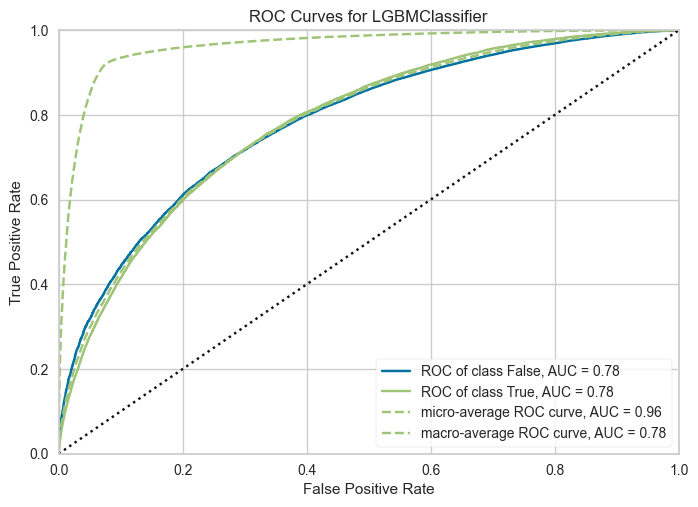

In [46]:
plot_model(tuned_lgbm, plot='auc')

##### 1.2 PRECISION RECALL Plot

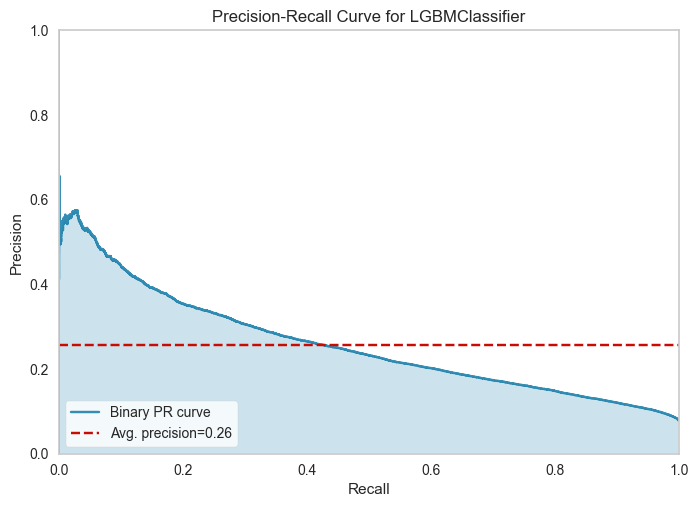

In [47]:
plot_model(tuned_lgbm, 'pr')

##### 1.3 Importância das Variáveis (Feature Importance) Plot

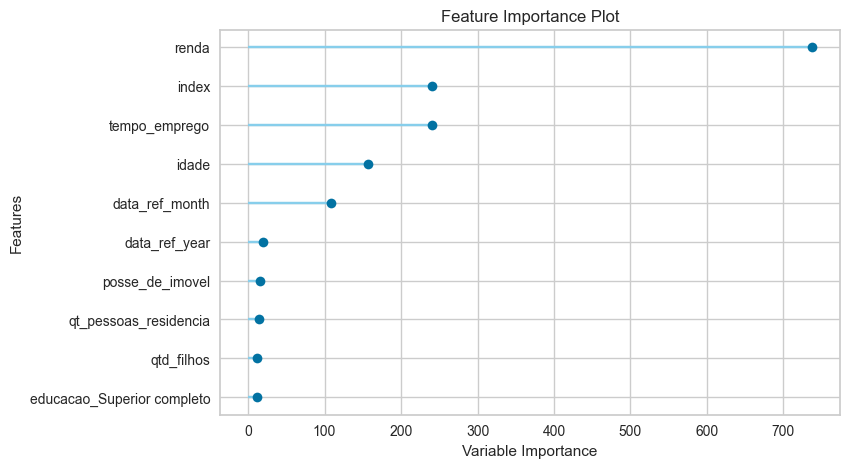

In [48]:
plot_model(tuned_lgbm, plot='feature')

##### 1.4 Matriz de Confusão

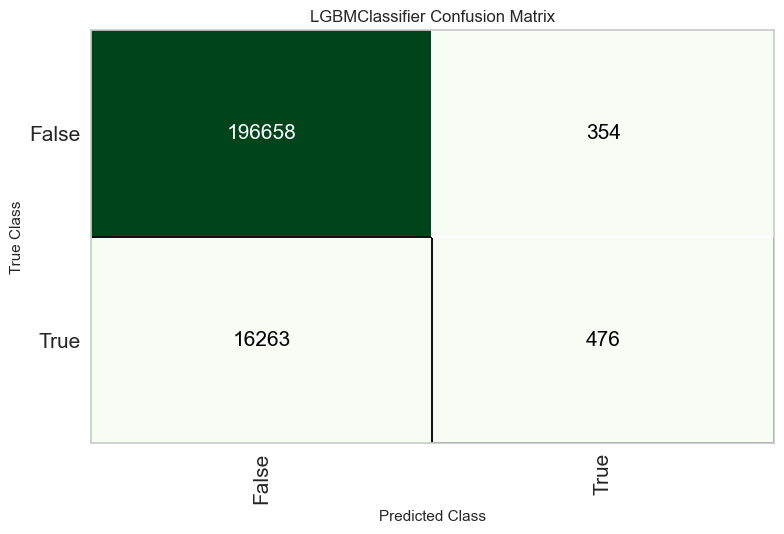

In [49]:
plot_model(tuned_lgbm, plot='confusion_matrix')

#### Avaliação do Modelo

In [55]:
evaluate_model(tuned_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### Predict na amostra de teste/hold-out

In [62]:
predict_model(lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9222,0.7820,0.0262,0.5703,0.0500,0.0435,0.1100


#### Finalizando o modelo para deploy

In [58]:
final_lgbm = finalize_model(tuned_lgbm)

In [59]:
print(final_lgbm)

Pipeline(memory=Memory(location=None),
         steps=[('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['data_ref'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['index', 'qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=Sim...
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=0.9,
                                importance_type='split', lear

In [61]:
predict_model(final_lgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9223,0.7843,0.0287,0.5719,0.0547,0.0476,0.1155


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [68]:
predict_model(final_lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9223,0.7843,0.0287,0.5719,0.0547,0.0476,0.1155


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
186385,2015-01-01,12523,F,N,N,0,Pensionista,Médio,Casado,Casa,53,NaN,2.0,986.169983,True,0,0.7166
649138,2015-07-01,6857,F,S,S,0,Assalariado,Médio,Casado,Casa,54,7.800000,2.0,9450.480469,False,0,0.9572
153815,2015-01-01,1575,F,N,N,0,Pensionista,Médio,Solteiro,Casa,57,NaN,1.0,2442.979980,False,0,0.8689
679371,2015-09-01,6220,M,S,N,0,Assalariado,Médio,Casado,Governamental,49,3.328767,2.0,48024.031250,False,0,0.9912
707257,2015-01-01,6067,F,N,S,0,Pensionista,Superior completo,Solteiro,Casa,58,NaN,1.0,2658.780029,False,0,0.8768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557146,2015-11-01,10776,F,N,N,0,Assalariado,Médio,Viúvo,Casa,56,15.443835,1.0,12201.860352,False,0,0.9703
323155,2015-09-01,7151,F,N,S,0,Empresário,Superior completo,Casado,Casa,47,3.293151,2.0,7894.149902,False,0,0.9512
239849,2016-03-01,13101,F,N,S,0,Assalariado,Médio,Casado,Casa,54,7.010959,2.0,2833.500000,False,0,0.8716
268243,2015-05-01,2595,M,S,N,0,Assalariado,Médio,Solteiro,Com os pais,31,9.065753,1.0,11249.870117,False,0,0.9671


#### Predizendo o conjunto de dados que não foi usado no treino

In [63]:
unseen_predictions = predict_model(final_lgbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9241,0.7843,0.0305,0.5000,0.0576,0.0493,0.1093


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,2015-01-01,5033,F,S,S,2,Servidor público,Fundamental,Casado,Casa,38,15.643836,4.0,4758.299805,False,0,0.9328
1,2015-01-01,1219,M,N,S,1,Empresário,Médio,Casado,Casa,38,0.753425,3.0,2506.479980,False,0,0.8713
2,2015-01-01,13262,M,S,N,0,Empresário,Médio,Solteiro,Casa,44,1.260274,1.0,936.010010,False,0,0.7148
3,2015-01-01,13598,M,S,N,2,Assalariado,Médio,Casado,Casa,49,3.016438,4.0,3996.300049,False,0,0.9043
4,2015-01-01,11700,M,S,N,0,Empresário,Médio,Casado,Casa,39,0.827397,2.0,3908.919922,False,0,0.9041


### Salvar o arquivo do modelo treinado

In [67]:
save_model(final_lgbm, 'Final LGBM Model 03Ago2024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['index', 'qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=Sim...
                                 boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, feature_fraction=0.9,
                                 importance_typ

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.